In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
import argparse
import gym
from gym import spaces
import numpy as np


import time
from google.protobuf import message
import grpc
try:
    import GrabSim_pb2_grpc
    import GrabSim_pb2
except:
    import os;
    os.chdir("./Env/")
    import GrabSim_pb2_grpc
    import GrabSim_pb2
import numpy as np
# import matplotlib.pyplot as plt
import cv2



import gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

# 参数


# train22 modify Extractor
import os
from Env.SimEnv4 import SimEnv
client='localhost:30007'
action_nums=8
bins = 50
mode='grasping'

use_image = True
max_steps = 50
channel = grpc.insecure_channel(client,options=[
            ('grpc.max_send_message_length', 1024*1024*1024),
            ('grpc.max_receive_message_length', 1024*1024*1024)
        ])

print('start')


stub=GrabSim_pb2_grpc.GrabSimStub(channel)
initworld = stub.Init(GrabSim_pb2.Count(value = 1))
# initworld = stub.Init(GrabSim_pb2.NUL())
# print(stub.AcquireAvailableMaps(GrabSim_pb2.NUL()))
map_id=4
# initworld = stub.SetWorld(GrabSim_pb2.BatchMap(count=2, mapID=map_id))
time.sleep(3)
scene = stub.Observe(GrabSim_pb2.SceneID(value=0))
print('------------------show_env_info----------------------')
print(
    f"sceneID:{scene.sceneID}, location:{[scene.location.X, scene.location.Y]}, rotation:{scene.rotation}\n",
    f"joints number:{len(scene.joints)}, fingers number:{len(scene.fingers)}\n", f"objects number: {len(scene.objects)}\n"
    f"velocity:{scene.velocity}, rotation:{scene.rotating}, timestep:{scene.timestep}\n"
    # f"timestamp:{scene.timestamp}, collision:{scene.collision}, info:{scene.info}"
    )



env=SimEnv(client,0,action_nums=action_nums,bins=bins,use_image=use_image,max_steps = max_steps,mode=mode)



start
------------------show_env_info----------------------
sceneID:0, location:[64.47500610351562, 5.067022357252426e-10], rotation:Yaw: 180.0

 joints number:21, fingers number:10
 objects number: 1
velocity:0.0, rotation:0.0, timestep:0

successfully initialized


In [2]:
joints_arrange = [
        [-36,30], #全身前后（摇摆，包括腿）
        [-90,90], #躯体左右 (旋转，不是摇摆)
        [-45,45], #上半身前后（摇摆，不包括腿）
        [-45,45], #上半身左右（摇摆，不包括腿）
        [-180,180], #头旋转（扭脖子）
        [-45,36], #头前后（点头）
        [-23,23], #头左右 (摇头) 

        #左手
        [-180,36], #肩关节，整条手臂前后
        [-23,90], #肩关节，整条手臂左右
        [-90,90], #肘关节，小臂旋转
        [-120,12], #肘关节，小臂前后
        [-90,90], #腕关节，手掌旋转 [-90,90],
        [-23,23], #腕关节，手掌前后
        [-36,23], #腕关节，手掌左右

        #右手
        [-180,36], #肩关节，整条手臂前后
        [-90,23], #肩关节，整条手臂左右
        [-90,90], #肘关节，小臂旋转
        [-120,12], #肘关节，小臂前后
        [-90,90], #腕关节，手掌旋转
        [-23,23], #腕关节，手掌前后
        [-23,36], #腕关节，手掌左右

        #grasp
        [0,1], # 是否抓取，此为离散值
    ]
    # joints_arrange=joints_arrange/np.pi*180
joints_arrange=np.array(joints_arrange,dtype=np.float32)

In [3]:
import re
f=open('RLexpert/0816_two_obj_data.txt')



data=[]
for line in f.readlines():
    line = line.strip('\n') 
    data.append(line)

datas=[]
last_index=0
for i in range(len(data)):
    if data[i]=='':
        datas.append(data[last_index:i])
        last_index=i+1
df=[]
for i in datas:
    data=[]
    for j in i:
        result = re.split(',|;', j)
        numbers=list(map(float, result))
        data.append(numbers)
    df.append(data)

In [10]:
import torch
import os
from Model import RT1

bins=256
device='cuda'
model=RT1.RT1_state(7,bins).to(device)


load_state_dict=torch.load('work_dir/rl090419/model_2.pth') 



model.load_state_dict(load_state_dict['model'])
model.eval()

Loaded pretrained weights for efficientnet-b3


RT1State(
  (RT1): RT1(
    (efficientnet): FilmEfficientNet(
      (conv_stem): Sequential(
        (0): Conv2dStaticSamePadding(
          3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
          (static_padding): ZeroPad2d((0, 1, 0, 1))
        )
        (1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      )
      (MBConvs): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            40, 10, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            10, 40, kernel_size=(1, 1), stride=(1, 1)


In [5]:
def action_untokenization(env, action,bins):
        # action=action.argmax(axis=-1)
        
        joints=action*(joints_arrange[-8:-1,1]-joints_arrange[-8:-1,0])/50
        return joints
        

In [11]:
import matplotlib.pyplot as plt 
import pickle

from Env.gen_data import name_type,gen_objs

def genObjwithLists(sim_client,sceneID,objList):
    for x,y,z,yaw,type in objList:
        obj_list = [GrabSim_pb2.ObjectList.Object(x=x, y=y, yaw=yaw, z=z, type=type)]
        # obj_list = [GrabSim_pb2.ObjectList.Object(X=ginger_loc[0] + x_rand, Y=ginger_loc[1] + y_rand, Yaw=yaw_rand, Z=h, type=type_rand)]
        scene = sim_client.MakeObjects(GrabSim_pb2.ObjectList(objects=obj_list, sceneID=sceneID))

def get_image(sim_client,sceneID):
    caremras=[GrabSim_pb2.CameraName.Head_Color]
    action = GrabSim_pb2.CameraList(sceneID=sceneID, cameras=caremras)
    im = sim_client.Capture(action).images[0]
    mat = np.frombuffer(im.data,dtype=im.dtype).reshape((im.height, im.width, im.channels))
    return mat

def get_depth(sim_client,sceneID):
    caremras=[GrabSim_pb2.CameraName.Head_Depth]
    action = GrabSim_pb2.CameraList(sceneID=sceneID, cameras=caremras)
    im = sim_client.Capture(action).images[0]
    mat = np.frombuffer(im.data,dtype=im.dtype).reshape((im.height, im.width, im.channels))
    t=100 #150
    mat = 1.0 * mat
    mat[mat>t]=t
    return mat
        
datas=[]

import random
import pandas as pd

def is_element_in_string(element_list, target_string):
    for element in element_list:
        if element in target_string:
            return True
    return False


def grasp(data,last_joints,level=1):
    instr=data['instruction']
    
    max_steps=50
    max_collision=0
    for _ in range(max_steps):
        obs=env.getCamera()[:,:,:3]
        img=torch.Tensor(obs)
        img=img.reshape(-1,1,*img.shape).permute(0,4,1,2,3).to(device)
        ed_camera=time.time()
        
        state=env.getState()
        state[3:3+21]/=(joints_arrange[:21,1]-joints_arrange[:21,0])/10
        state[3+21:3+21+3]/=10
        state=torch.Tensor(state[-8-3:]).to(device).unsqueeze(0)

        action=model(img,[instr],state)

        action=action[0].cpu().detach().numpy()
        you_joints=action_untokenization(env,action,bins)
        joints=last_joints[:].copy()
        joints[-8:-1]=you_joints+joints[-8:-1]

        
        last_joints=joints

        msg,collision=env.changeJoints(joints[:21])

        data['track'].append(joints[:21])
        
        arrive=False

        if env.check_grasp('grasping')[1]:
            arrive=True
        if arrive:
            data['info']='success'
            data['detail']=collision
            break
        
        if len(collision)>0:
            flag=True
            for collision_info in re.split(',|;', collision):
                    if collision_info[-1]=='O' or collision_info[2]=='3':
                        flag=False
                        break
            if flag==False:
                if max_collision>0:
                    max_collision-=1
                else:
                    data['info']='collision'
                    data['detail']=collision
                    break
            
        
        time.sleep(0.03)

        
        if _==max_steps-1:
            data['info']='time exceed'
            break
        
    return data


num: 1, success rate:100.00%
Instruction:  I need to buy a tube of Yogurt with blue and white stripe packaging. \ 
 
targetObj: Yogurt
done at 20 steps


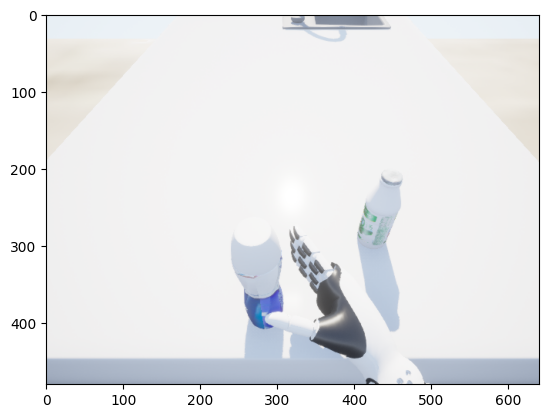

num: 2, success rate:100.00%
Instruction:  I need a bottle of ADMilk, the fortified milk with vitamins and minerals, with a white cap and green \ 
  ADMilk label.
targetObj: ADMilk
done at 21 steps
num: 3, success rate:66.67%
Instruction:  I need a bottle of ADMilk as I am looking for a milk fortified with vitamins and minerals for additi \ 
 onal nutrition.
targetObj: ADMilk
done at 13 steps
num: 4, success rate:75.00%
Instruction:  Hey there Robot, could you please grab the Yogurt on the Front-Left side of the scene for me? I'm in \ 
  the mood for some healthy and convenient yogurt and that's within easy reach. Thanks a bunch!
targetObj: Yogurt
done at 21 steps
num: 5, success rate:80.00%
Instruction:  I need a tube of toothpaste with a white label and a red cap, preferably Colgate, for brushing my te \ 
 eth. Can you please get it for me?
targetObj: Toothpaste
done at 24 steps
num: 6, success rate:83.33%
Instruction:  I would like to buy a tube of yogurt with the blue and white str

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 18>:51                                                                            │
│                                                                                                  │
│   48 │   initJoints[5]=35                                                                        │
│   49 │   initJoints=np.array(initJoints)                                                         │
│   50 │                                                                                           │
│ ❱ 51 │   env.changeJoints(initJoints)                                                            │
│   52 │                                                                                           │
│   53 │   last_joints=np.array(list(initJoints)+[0,])                                             │
│   54 │   time.sleep(1)                                                                           │
│                                                                                                  │
│ /data2/maliang/zhangkaidong/IL/RM-PRT/Env/SimEnv4.py:208 in changeJoints                         │
│                                                                                                  │
│   205 │   │   │   self.not_move_for_limit+=1                                                     │
│   206 │   │   │   return False                                                                   │
│   207 │   │                                                                                      │
│ ❱ 208 │   │   message = self.stub.Do(GrabSim_pb2.Action(sceneID=self.sceneID, action = GrabSim   │
│   209 │   │   if message.info=='Unreachable':                                                    │
│   210 │   │   │   print('Unreachable')                                                           │
│   211 │   │   │   return False                                                                   │
│                                                                                                  │
│ /data1/maliang/miniconda3/envs/simRT1/lib/python3.8/site-packages/grpc/_channel.py:1028 in       │
│ __call__                                                                                         │
│                                                                                                  │
│   1025 │   │   │   │    credentials: Optional[grpc.CallCredentials] = None,                      │
│   1026 │   │   │   │    wait_for_ready: Optional[bool] = None,                                   │
│   1027 │   │   │   │    compression: Optional[grpc.Compression] = None) -> Any:                  │
│ ❱ 1028 │   │   state, call, = self._blocking(request, timeout, metadata, credentials,            │
│   1029 │   │   │   │   │   │   │   │   │     wait_for_ready, compression)                        │
│   1030 │   │   return _end_unary_response_blocking(state, call, False, None)                     │
│   1031                                                                                           │
│                                                                                                  │
│ /data1/maliang/miniconda3/envs/simRT1/lib/python3.8/site-packages/grpc/_channel.py:1017 in       │
│ _blocking                                                                                        │
│                                                                                                  │
│   1014 │   │   │   │   │   operations,                                                           │
│   1015 │   │   │   │   │   None,                                                                 │
│   1016 │   │   │   │   ),), self._context)                                                       │
│ ❱ 1017 │   │   │   event = call.next_event()                                                     │
│   1018 │   │   │   _handle_event(event, state, self._respon

In [12]:
import pandas as pd

success=0
rule_success=0
rule_num=0
total_num=0

loc_grasp=[]
datas=[]

level=3 # task level
instructions=pd.read_csv('instructions/training.csv')
instructions=instructions[instructions['level']==level]

    


for index,data in enumerate(random.choices(df,k=400)):
    x,y=env.scene.location.X,env.scene.location.Y

    can_list = [6, 2, 5]
    objList=[]
    
    for i in range(len(data[0])//3):
        dx,dy,dz=data[0][i*3],data[0][i*3+1],data[0][i*3+2]-9.425+3
        # dz=98
        if i==0:
            obj_id=random.choice(can_list)
            target_id=obj_id
            env.targetObj=name_type[obj_id]
        else:

            obj_id=random.choice([x for x in can_list if x !=target_id])
            disturb_id=obj_id
            dz=objList[0][2]
        obj = name_type[obj_id]
        objList.append([x+dx,y+dy,dz,0,obj_id])


    scene = stub.Reset(GrabSim_pb2.ResetParams(adjust=True, height=dz))


    time.sleep(1)
    genObjwithLists(stub,0,objList)
    
    env.targetid,_=env.get_nearest_obj(env.targetObj)
    initJoints = [0]*14+data[1]
    initJoints[5]=35
    initJoints=np.array(initJoints)
 
    env.changeJoints(initJoints)
 
    last_joints=np.array(list(initJoints)+[0,])
    time.sleep(1)
    data={}
    data['objs']=[]
    for x,y,z,yaw,otype in objList:
        data['objs'].append([otype,x,y,z,yaw])
    data['initJoints']=initJoints
    data['detail']=''
    data['track']=[]

    if level>2:
        df_conditioned=instructions[instructions['object']==env.targetObj]
        instr = df_conditioned.sample()['instruction'].values[0]
    else:
        instr = 'pick a '+env.targetObj
    data['instruction']=instr
    

    data=grasp(data,last_joints,level=level)
    
    datas.append(data)
    with open('trajectory.pkl','wb') as f:
        pickle.dump(datas,f)

    if data['info']=='success':
        success+=1

    total_num+=1
    print(f'num: {total_num}, success rate:{success/total_num*100:.2f}%')
    print('Instruction: ',instr[:100],'\\',"\n",instr[100:])
    time.sleep(1)
    if data['info'] in ['success','collision','time exceed']: 
        print('targetObj:',env.targetObj)
        print(f"done at {len(data['track'])} steps")
        # print(data['detail'])
        if index==0:
            im=get_image(env.stub,env.sceneID)
            plt.imshow(im)
            plt.show() 
    
    
    